In [1]:
import numpy as np
import seaborn as sns

import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
X_test = pd.read_csv("/home/ali/Desktop/MAP569_Project/AMF_test_X_uDs0jHH.csv")
X_train = pd.read_csv("/home/ali/Desktop/MAP569_Project/AMF_train_X_XCZw8r3.csv")
Y_train = pd.read_csv("/home/ali/Desktop/MAP569_Project/AMF_train_Y_omYQJZL.csv")

In [3]:
### Converting Date and Share to the numeric value
def ds_to_numeric( data ):
    for i in range(len(data['Day'])):
        # -5 because each feature starts with Date_
        day_len = 5 - len(data['Day'][i])  
        data['Day'][i] = int(data['Day'][i][day_len:])

        share_len = 5 - len(data['Share'][i]) 
        data['Share'][i] = int(data['Share'][i][share_len:])
    
    data['Day'] = pd.to_numeric(data['Day']) 
    data['Share'] = pd.to_numeric(data['Share'])
 

### Replacement by median the nan values
def nan_to_median(data):
    data['OTR'].fillna(1.0,inplace=True)
    data['OMR'].fillna(1.0,inplace=True)

    data['min_dt_TV1'].fillna(data['min_dt_TV1'].median(),inplace=True)
    data['mean_dt_TV1'].fillna(data['mean_dt_TV1'].median(),inplace=True)
    data['med_dt_TV1'].fillna(data['med_dt_TV1'].median(),inplace=True)
    data['min_dt_TV1_TV2'].fillna(data['min_dt_TV1_TV2'].median(),inplace=True)
    data['mean_dt_TV1_TV2'].fillna(data['mean_dt_TV1_TV2'].median(),inplace=True)
    data['med_dt_TV1_TV2'].fillna(data['med_dt_TV1_TV2'].median(),inplace=True)
    data['min_dt_TV1_TV3'].fillna(data['min_dt_TV1_TV3'].median(),inplace=True)
    data['mean_dt_TV1_TV3'].fillna(data['mean_dt_TV1_TV3'].median(),inplace=True)
    data['med_dt_TV1_TV3'].fillna(data['med_dt_TV1_TV3'].median(),inplace=True)
    data['min_dt_TV1_TV4'].fillna(data['min_dt_TV1_TV4'].median(),inplace=True)
    data['mean_dt_TV1_TV4'].fillna(data['mean_dt_TV1_TV4'].median(),inplace=True)
    data['med_dt_TV1_TV4'].fillna(data['med_dt_TV1_TV4'].median(),inplace=True)

### Log scaling
def scale(data):
    columns = ['mean_time_two_events', '10_p_time_two_events', 'med_time_two_events', '25_p_time_two_events','OTR',
               '75_p_time_two_events', '90_p_time_two_events', 'min_lifetime_cancel', 'mean_lifetime_cancel','OCR',
               '10_p_lifetime_cancel', 'med_lifetime_cancel', '25_p_lifetime_cancel', '75_p_lifetime_cancel', 'OMR',
               '90_p_lifetime_cancel', 'max_lifetime_cancel', 'NbTradeVenueMic', 'MaxNbTradesBySecond','min_dt_TV1',
               'MeanNbTradesBySecond', 'mean_dt_TV1', 'med_dt_TV1', 'min_dt_TV1_TV2', 'mean_dt_TV1_TV2', 'med_dt_TV1_TV2',
               'min_dt_TV1_TV3', 'mean_dt_TV1_TV3', 'med_dt_TV1_TV3', 'min_dt_TV1_TV4', 'mean_dt_TV1_TV4','med_dt_TV1_TV4']
    for col in columns:
        data[col] = np.log( data[col] + 1 )

        
def histogram(data):
    fig, axs = plt.subplots(6,6,figsize=(30, 30) )
    columns = data.columns[4:]
    for i in range(6):
        for j in range(6):
            if i < 5 or j < 1:
                axs[i,j].hist(data[columns[i*6+j]])
                axs[i,j].set_title(columns[i*6+j])        
        

def save_csv(filename, test):
    with open(filename, 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['Trader', 'type'])
        for data in test:
            filewriter.writerow([str(data), str(test[data])])

In [4]:
clas = []
for i in range(105782):
    for j in range(86):
        if X_train['Trader'][i] == Y_train['Trader'][j]:
            clas.append(Y_train['type'][j])
            break

In [5]:
y = pd.get_dummies(clas)

### Pre-processing the X_train

In [6]:
X_train = X_train.drop('Trader', axis=1)
X_train = X_train.drop('Index', axis=1)
X_train = X_train.drop('Day', axis=1)
X_train = X_train.drop('Share', axis=1)
nan_to_median(X_train)
scale(X_train)    

### Pre-processing the X_test

In [7]:
Traders = X_test['Trader'].copy()
X_test = X_test.drop('Trader', axis=1)
X_test = X_test.drop('Index', axis=1)
X_test = X_test.drop('Day', axis=1)
X_test = X_test.drop('Share', axis=1)
nan_to_median(X_test)
scale(X_test)    

### CORRELATION MATRIX

<AxesSubplot:>

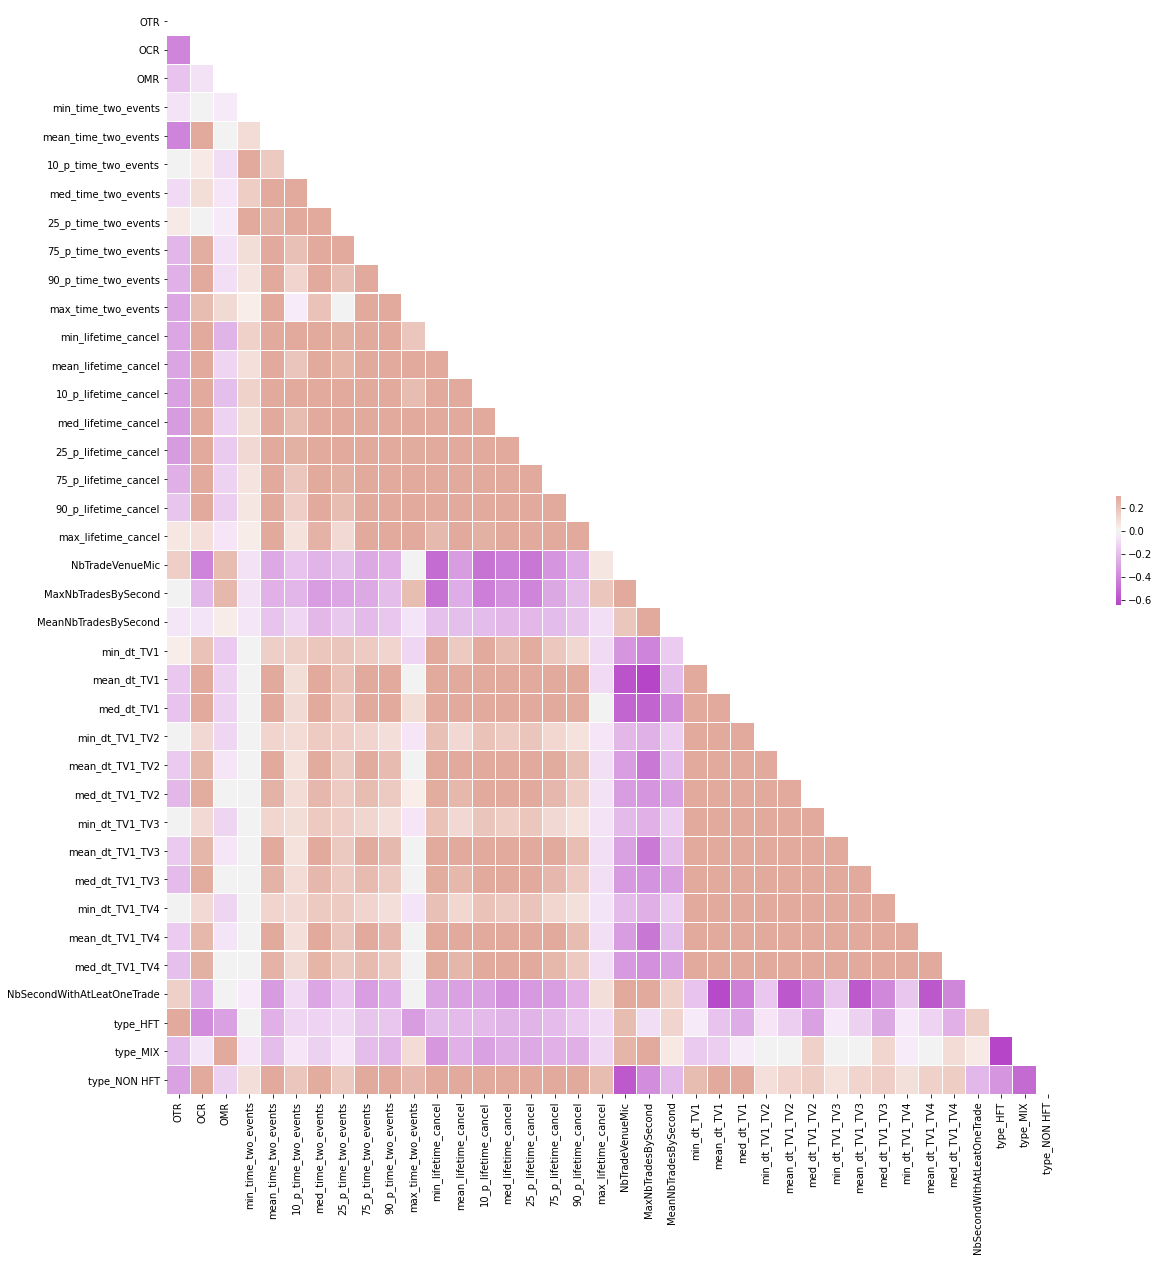

In [199]:
data = X_train.copy()
data['type'] = clas
hft = pd.get_dummies(data.type, prefix='type')['type_HFT']
mix = pd.get_dummies(data.type, prefix='type')['type_MIX']
non = pd.get_dummies(data.type, prefix='type')['type_NON HFT']

data['type_HFT'] = hft
data['type_MIX'] = mix 
data['type_NON HFT'] = non

corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(300, 20, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=0.1, cbar_kws={"shrink": .1}, ax = ax)

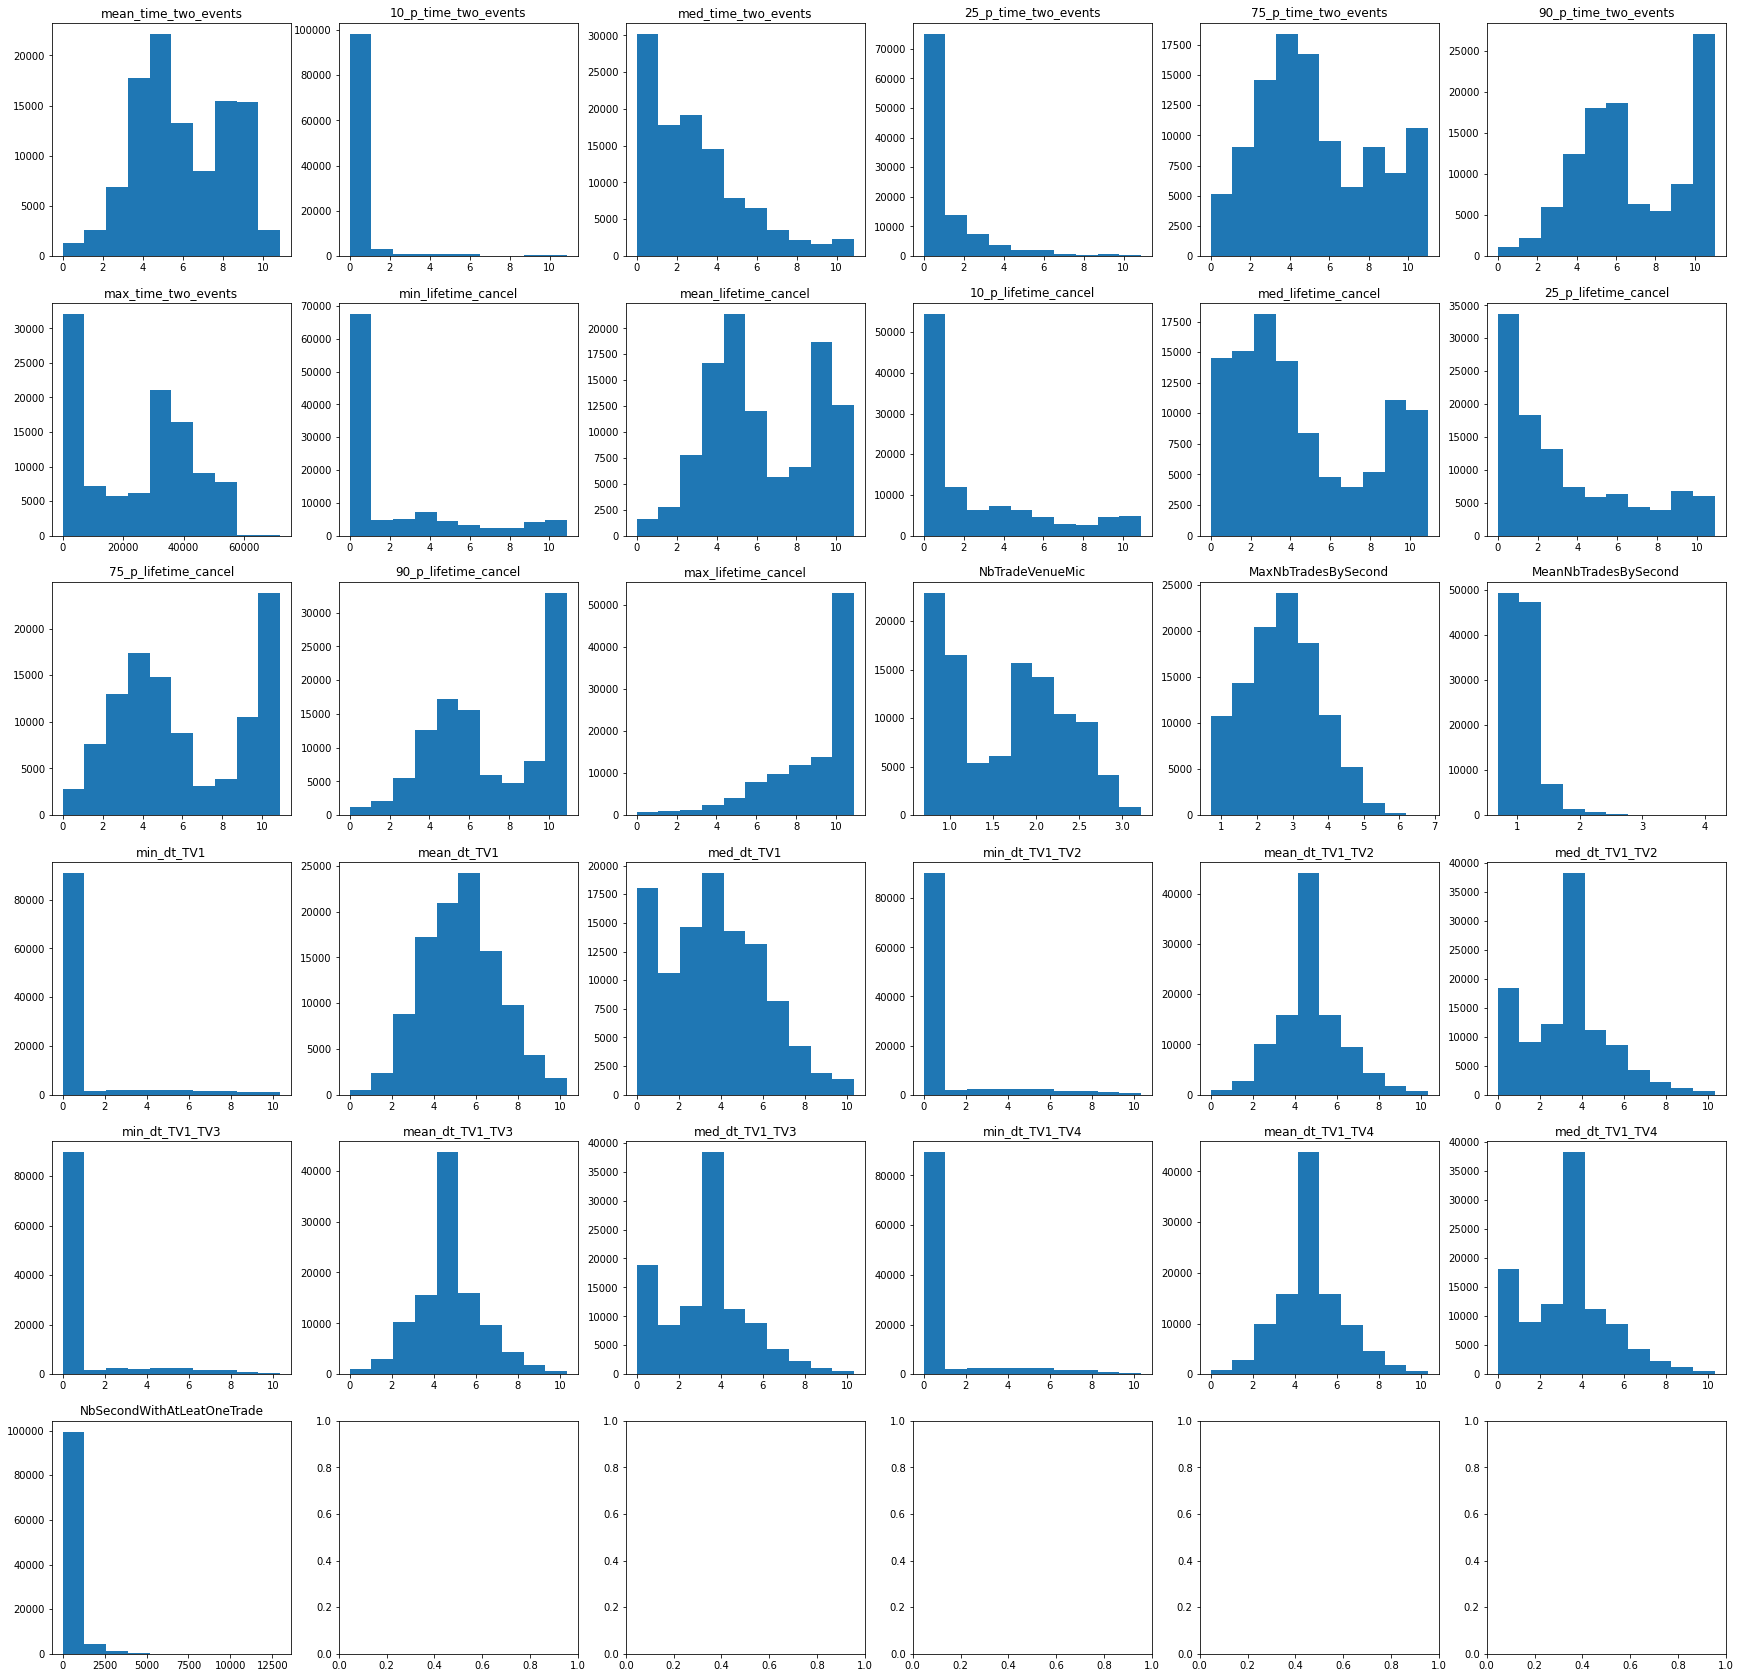

In [200]:
histogram(X_train)

In [264]:
# Training
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

nRows = X_train.shape[0]
nCols = X_train.shape[1]

print(X_train.shape)
print(y.shape)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y)


(105782, 37)
(105782, 3)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [265]:
print("Train accuracy", clf.score(X_train, y))

Train accuracy 0.713665841069369


/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [44]:
test = {}
for i in range(len(Traders)):
    if Traders[i] in test.keys():
        test[Traders[i]] += y_test[i]
    else:
        test[Traders[i]] = y_test[i]
        
for i in test:
    if np.argmax(test[i]) == 0:
        test[i] = 'HFT'
    elif np.argmax(test[i]) == 1:
        test[i] = 'MIX'
    else :
        test[i] = 'NON HFT'

In [45]:
save_csv('cat.csv', test)

In [201]:
# Training: XGB
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1,max_depth=1, random_state=0)
print(X_train.shape)
print(y.shape)
clf.fit(X_train, clas)
print(clf.score(X_train, clas))
y_test = clf.predict(X_test)

(105782, 35)
(105782, 3)
0.9461345030345427


In [215]:
### FOR XGB

def dummies(buf):
    if buf=='HFT':
        return [1,0,0]
    elif buf=='MIX':
        return [0,1,0]
    else:
        return [0,0,1]

test = {}
for i in range(len(Traders)):
    if Traders[i] in test.keys():
        
        test[Traders[i]] += dummies(y_test[i])
    else:
        test[Traders[i]] = dummies(y_test[i])
        
for i in test:
    if np.argmax(test[i]) == 0:
        test[i] = 'HFT'
    elif np.argmax(test[i]) == 1:
        test[i] = 'MIX'
    else :
        test[i] = 'NON HFT'

save_csv('cat.csv', test)

In [204]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split

In [208]:

clf = xgb.XGBClassifier()
clf.fit(X_train, clas)
print(clf.score(X_train, clas))
y_test = clf.predict(X_test)

/home/ali/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9963131723733717


In [209]:
y_test

array(['MIX', 'NON HFT', 'NON HFT', ..., 'MIX', 'MIX', 'MIX'], dtype='<U7')

In [213]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier()
clf.fit(X_train, clas)
print(clf.score(X_train, clas))

Learning rate set to 0.100362
0:	learn: 0.9730854	total: 82.4ms	remaining: 1m 22s
1:	learn: 0.8740660	total: 107ms	remaining: 53.3s
2:	learn: 0.7956279	total: 138ms	remaining: 45.8s
3:	learn: 0.7323223	total: 158ms	remaining: 39.3s
4:	learn: 0.6773833	total: 180ms	remaining: 35.9s
5:	learn: 0.6317519	total: 206ms	remaining: 34.2s
6:	learn: 0.5901118	total: 231ms	remaining: 32.7s
7:	learn: 0.5539755	total: 252ms	remaining: 31.3s
8:	learn: 0.5233772	total: 273ms	remaining: 30s
9:	learn: 0.4960901	total: 292ms	remaining: 28.9s
10:	learn: 0.4715077	total: 313ms	remaining: 28.1s
11:	learn: 0.4508904	total: 334ms	remaining: 27.5s
12:	learn: 0.4315649	total: 354ms	remaining: 26.9s
13:	learn: 0.4159686	total: 374ms	remaining: 26.3s
14:	learn: 0.4012952	total: 393ms	remaining: 25.8s
15:	learn: 0.3867506	total: 413ms	remaining: 25.4s
16:	learn: 0.3713394	total: 438ms	remaining: 25.3s
17:	learn: 0.3579304	total: 459ms	remaining: 25.1s
18:	learn: 0.3469084	total: 478ms	remaining: 24.7s
19:	learn: 

167:	learn: 0.0972472	total: 3.6s	remaining: 17.8s
168:	learn: 0.0970062	total: 3.62s	remaining: 17.8s
169:	learn: 0.0967708	total: 3.64s	remaining: 17.8s
170:	learn: 0.0964483	total: 3.66s	remaining: 17.8s
171:	learn: 0.0962297	total: 3.68s	remaining: 17.7s
172:	learn: 0.0959358	total: 3.7s	remaining: 17.7s
173:	learn: 0.0956636	total: 3.72s	remaining: 17.6s
174:	learn: 0.0953795	total: 3.73s	remaining: 17.6s
175:	learn: 0.0950095	total: 3.75s	remaining: 17.6s
176:	learn: 0.0948029	total: 3.77s	remaining: 17.5s
177:	learn: 0.0944301	total: 3.79s	remaining: 17.5s
178:	learn: 0.0942995	total: 3.81s	remaining: 17.5s
179:	learn: 0.0941131	total: 3.83s	remaining: 17.4s
180:	learn: 0.0939032	total: 3.85s	remaining: 17.4s
181:	learn: 0.0937587	total: 3.86s	remaining: 17.4s
182:	learn: 0.0935689	total: 3.88s	remaining: 17.3s
183:	learn: 0.0933350	total: 3.92s	remaining: 17.4s
184:	learn: 0.0930092	total: 3.94s	remaining: 17.4s
185:	learn: 0.0927750	total: 3.97s	remaining: 17.4s
186:	learn: 0.

332:	learn: 0.0691281	total: 7.18s	remaining: 14.4s
333:	learn: 0.0689400	total: 7.21s	remaining: 14.4s
334:	learn: 0.0688214	total: 7.24s	remaining: 14.4s
335:	learn: 0.0687457	total: 7.25s	remaining: 14.3s
336:	learn: 0.0686437	total: 7.27s	remaining: 14.3s
337:	learn: 0.0685573	total: 7.29s	remaining: 14.3s
338:	learn: 0.0684858	total: 7.31s	remaining: 14.3s
339:	learn: 0.0684294	total: 7.33s	remaining: 14.2s
340:	learn: 0.0683089	total: 7.34s	remaining: 14.2s
341:	learn: 0.0682302	total: 7.36s	remaining: 14.2s
342:	learn: 0.0680932	total: 7.38s	remaining: 14.1s
343:	learn: 0.0680297	total: 7.41s	remaining: 14.1s
344:	learn: 0.0679855	total: 7.42s	remaining: 14.1s
345:	learn: 0.0678718	total: 7.44s	remaining: 14.1s
346:	learn: 0.0678510	total: 7.46s	remaining: 14s
347:	learn: 0.0677835	total: 7.47s	remaining: 14s
348:	learn: 0.0677336	total: 7.49s	remaining: 14s
349:	learn: 0.0676129	total: 7.51s	remaining: 13.9s
350:	learn: 0.0675373	total: 7.53s	remaining: 13.9s
351:	learn: 0.0675

501:	learn: 0.0572501	total: 10.4s	remaining: 10.3s
502:	learn: 0.0572371	total: 10.4s	remaining: 10.3s
503:	learn: 0.0571997	total: 10.4s	remaining: 10.3s
504:	learn: 0.0571473	total: 10.5s	remaining: 10.3s
505:	learn: 0.0571063	total: 10.5s	remaining: 10.2s
506:	learn: 0.0570662	total: 10.5s	remaining: 10.2s
507:	learn: 0.0569529	total: 10.5s	remaining: 10.2s
508:	learn: 0.0568837	total: 10.5s	remaining: 10.2s
509:	learn: 0.0568634	total: 10.6s	remaining: 10.1s
510:	learn: 0.0568065	total: 10.6s	remaining: 10.1s
511:	learn: 0.0567777	total: 10.6s	remaining: 10.1s
512:	learn: 0.0566977	total: 10.6s	remaining: 10.1s
513:	learn: 0.0566151	total: 10.6s	remaining: 10.1s
514:	learn: 0.0565743	total: 10.7s	remaining: 10s
515:	learn: 0.0565296	total: 10.7s	remaining: 10s
516:	learn: 0.0565059	total: 10.7s	remaining: 10s
517:	learn: 0.0564953	total: 10.8s	remaining: 10s
518:	learn: 0.0564680	total: 10.8s	remaining: 9.99s
519:	learn: 0.0564162	total: 10.8s	remaining: 9.97s
520:	learn: 0.056374

665:	learn: 0.0497209	total: 13.8s	remaining: 6.94s
666:	learn: 0.0497031	total: 13.9s	remaining: 6.92s
667:	learn: 0.0496807	total: 13.9s	remaining: 6.9s
668:	learn: 0.0496515	total: 13.9s	remaining: 6.88s
669:	learn: 0.0496130	total: 13.9s	remaining: 6.86s
670:	learn: 0.0495909	total: 13.9s	remaining: 6.84s
671:	learn: 0.0495432	total: 14s	remaining: 6.82s
672:	learn: 0.0494956	total: 14s	remaining: 6.79s
673:	learn: 0.0494605	total: 14s	remaining: 6.77s
674:	learn: 0.0494359	total: 14s	remaining: 6.75s
675:	learn: 0.0494017	total: 14s	remaining: 6.73s
676:	learn: 0.0493878	total: 14.1s	remaining: 6.71s
677:	learn: 0.0493710	total: 14.1s	remaining: 6.69s
678:	learn: 0.0493383	total: 14.1s	remaining: 6.67s
679:	learn: 0.0492576	total: 14.1s	remaining: 6.65s
680:	learn: 0.0492309	total: 14.1s	remaining: 6.63s
681:	learn: 0.0491744	total: 14.2s	remaining: 6.61s
682:	learn: 0.0491591	total: 14.2s	remaining: 6.58s
683:	learn: 0.0491415	total: 14.2s	remaining: 6.56s
684:	learn: 0.0491067	t

830:	learn: 0.0442509	total: 17.3s	remaining: 3.51s
831:	learn: 0.0442145	total: 17.3s	remaining: 3.49s
832:	learn: 0.0441758	total: 17.3s	remaining: 3.47s
833:	learn: 0.0441481	total: 17.3s	remaining: 3.45s
834:	learn: 0.0441365	total: 17.4s	remaining: 3.43s
835:	learn: 0.0440958	total: 17.4s	remaining: 3.41s
836:	learn: 0.0440661	total: 17.4s	remaining: 3.39s
837:	learn: 0.0440049	total: 17.4s	remaining: 3.37s
838:	learn: 0.0439033	total: 17.5s	remaining: 3.35s
839:	learn: 0.0438687	total: 17.5s	remaining: 3.33s
840:	learn: 0.0438200	total: 17.5s	remaining: 3.31s
841:	learn: 0.0437255	total: 17.5s	remaining: 3.29s
842:	learn: 0.0436546	total: 17.6s	remaining: 3.27s
843:	learn: 0.0436315	total: 17.6s	remaining: 3.25s
844:	learn: 0.0436138	total: 17.6s	remaining: 3.23s
845:	learn: 0.0435913	total: 17.6s	remaining: 3.21s
846:	learn: 0.0435737	total: 17.6s	remaining: 3.19s
847:	learn: 0.0435554	total: 17.7s	remaining: 3.17s
848:	learn: 0.0435443	total: 17.7s	remaining: 3.14s
849:	learn: 

994:	learn: 0.0395701	total: 20.7s	remaining: 104ms
995:	learn: 0.0395520	total: 20.7s	remaining: 83.2ms
996:	learn: 0.0395259	total: 20.7s	remaining: 62.4ms
997:	learn: 0.0394915	total: 20.8s	remaining: 41.6ms
998:	learn: 0.0394651	total: 20.8s	remaining: 20.8ms
999:	learn: 0.0394550	total: 20.8s	remaining: 0us
0.9897997768996616


In [214]:
y_test = clf.predict(X_test)

In [15]:
X_train.shape[1]

35

In [27]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import TensorBoard

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time
import pickle

import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

LOG_DIR = f"{int(time.time())}"

tensorboard = TensorBoard(log_dir=LOG_DIR)

def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Dense(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), input_shape=X_train.shape[1:],
                                activation='relu',
                                kernel_initializer='random_normal'))

    for i in range(hp.Int('n_layers', 1, 10)):  # adding variation of layers.
        model.add(Dense(hp.Int(f'layer_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                                activation='relu',
                                kernel_initializer='random_normal'))
        
    model.add(Dense(3, activation='relu', kernel_initializer='random_normal'))
    model.add(Activation("softmax"))


    model.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
              
    return model
                  

tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=20,  # how many variations on model?
    executions_per_trial=2,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)

tuner.search_space_summary()

tuner.search(x=X_train,
             y=y,
             epochs=3,
             batch_size=64,
             callbacks=[tensorboard])

tuner.results_summary()


# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)

Trial 20 Complete [00h 00m 06s]
accuracy: 0.3020787984132767

Best accuracy So Far: 0.7686232030391693
Total elapsed time: 00h 04m 42s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1616167080/untitled_project
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 32
n_layers: 4
layer_0_units: 64
layer_1_units: 32
layer_2_units: 32
layer_3_units: 32
Score: 0.7686232030391693
Trial summary
Hyperparameters:
input_units: 160
n_layers: 7
layer_0_units: 192
layer_1_units: 224
layer_2_units: 64
layer_3_units: 64
layer_4_units: 160
layer_5_units: 224
layer_6_units: 64
layer_7_units: 128
layer_8_units: 64
Score: 0.5323495417833328
Trial summary
Hyperparameters:
input_units: 96
n_layers: 9
layer_0_units: 160
layer_1_units: 192
layer_2_units: 96
layer_3_units: 224
layer_4_units: 192
layer_5_units: 96
layer_6_units: 224
layer_7_units: 96
layer_8_units: 32
Score: 0.5115898698568344
Trial summary
Hyperparameters:
input_units:

In [39]:
def build_model():  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Dense(256, input_shape=X_train.shape[1:],
                                activation='relu',
                                kernel_initializer='random_normal'))

    model.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(64, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
    model.add(Dense(16, activation='relu', kernel_initializer='random_normal'))

    model.add(Dense(3, activation='relu', kernel_initializer='random_normal'))
    model.add(Activation("softmax"))


    model.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
              
    return model
                  

In [40]:
model = build_model()

In [41]:
monitor = EarlyStopping(monitor='loss', min_delta=1e-4, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)

model.fit(X_train,y, callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
3306/3306 - 2s - loss: 0.8451 - accuracy: 0.5161
Epoch 2/1000
3306/3306 - 2s - loss: 0.6624 - accuracy: 0.6935
Epoch 3/1000
3306/3306 - 2s - loss: 0.5707 - accuracy: 0.7703
Epoch 4/1000
3306/3306 - 2s - loss: 0.5358 - accuracy: 0.7875
Epoch 5/1000
3306/3306 - 2s - loss: 0.4823 - accuracy: 0.8097
Epoch 6/1000
3306/3306 - 2s - loss: 0.4521 - accuracy: 0.8219
Epoch 7/1000
3306/3306 - 2s - loss: 0.4349 - accuracy: 0.8283
Epoch 8/1000
3306/3306 - 2s - loss: 0.4202 - accuracy: 0.8326
Epoch 9/1000
3306/3306 - 2s - loss: 0.4020 - accuracy: 0.8413
Epoch 10/1000
3306/3306 - 2s - loss: 0.3957 - accuracy: 0.8451
Epoch 11/1000
3306/3306 - 2s - loss: 0.3892 - accuracy: 0.8471
Epoch 12/1000
3306/3306 - 2s - loss: 0.3732 - accuracy: 0.8529
Epoch 13/1000
3306/3306 - 2s - loss: 0.3677 - accuracy: 0.8555
Epoch 14/1000
3306/3306 - 2s - loss: 0.3645 - accuracy: 0.8561
Epoch 15/1000
3306/3306 - 2s - loss: 0.3552 - accuracy: 0.8612
Epoch 16/1000
3306/3306 - 2s - loss: 0.3480 - accuracy: 0.8642
E

In [42]:
y_test = model.predict(X_test)

array([[4.96447593e-01, 2.54376382e-01, 2.49175996e-01],
       [2.55703419e-01, 2.55703419e-01, 4.88593221e-01],
       [5.31132281e-01, 1.15494214e-01, 3.53373468e-01],
       ...,
       [3.86157110e-02, 9.60923672e-01, 4.60618670e-04],
       [1.16933265e-03, 9.98811245e-01, 1.94407712e-05],
       [4.53341083e-04, 9.99540567e-01, 6.04648176e-06]], dtype=float32)